## Loading a United-atom cy5 representation into mbuild

In [1]:
import numpy as np
import mbuild as mb

/Users/stephaniemccallum/miniforge3/envs/flowermd/lib/python3.12/site-packages/gmso/core/element.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [18]:
dye = mb.load('../data/CY5-bonds.pdb')
dye.visualize().show()

/Users/stephaniemccallum/miniforge3/envs/flowermd/lib/python3.12/site-packages/mbuild/compound.py:546: UserWarning: Some particle of <Compound 58 particles, 61 bonds, non-periodic, id: 10789576944> does not have a charge.They will not be accounted for during this calculation.
  warn(


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

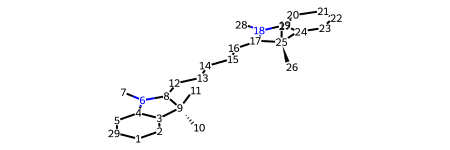

In [3]:
#use mbuild to remove carbon and hydrogen particles attatched to nitrogen linkers
from rdkit import Chem

def show_atom_number(mol, label):
    for atom in mol.GetAtoms():
        atom.SetProp(label, str(atom.GetIdx()+1))
    return mol
    
dye1 = Chem.MolFromPDBFile("../data/CY5-bonds.pdb",)
show_atom_number(dye1, 'atomLabel')
#add tether particle and bond
#fix tether particle position
#maybe restrict angle movement of bond or add surface

In [4]:
def remove_hydrogens(compound):
    """Removes atoms bonded to linker"""
    # Create a list of hydrogen atoms to be removed
    hydrogens_to_remove = [
        particle for particle in compound.particles() if particle.element.atomic_number == 1
    ]
    
    # Iterate and remove each hydrogen atom
    for particle in hydrogens_to_remove:
        compound.remove(particle)

    # Return the compound with hydrogens removed
    return compound

In [16]:
def rename_carbons_by_index(compound):
    """Removes atoms bonded to linker"""
    # Create a list of hydrogen atoms to be removed
    carbon_idx = ['C21','C22']
    carbons_to_remove = [
        particle for particle in compound.particles() if particle.name in carbon_idx
    ]
    
    for i,carbon in enumerate(carbons_to_remove):
        carbon.name = f'T{i}'
        print(carbon.name)

    # Return the compound with hydrogens removed
    return compound

In [19]:
uadye = remove_hydrogens(dye)
uadye = rename_carbons_by_index(uadye)

T0
T1


In [20]:
uadye.visualize().show()

/Users/stephaniemccallum/miniforge3/envs/flowermd/lib/python3.12/site-packages/mbuild/compound.py:546: UserWarning: Some particle of <Compound 29 particles, 32 bonds, non-periodic, id: 10791073984> does not have a charge.They will not be accounted for during this calculation.
  warn(


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
#add tether particle and bond

#fix tether particle position

#maybe restrict angle movement of bond or add surface

## Loading cy5 into flowerMD Molecule

In [44]:
from flowermd.base import Molecule, System, Lattice
import gsd.hoomd
import hoomd

In [39]:
dye = Molecule(num_mols=2,compound=uadye)

In [28]:
print(dye,dye.molecules)

<flowermd.base.molecule.Molecule object at 0x28a4f7ef0> [<Compound 29 particles, 32 bonds, non-periodic, id: 10916534496>, <Compound 29 particles, 32 bonds, non-periodic, id: 10931574144>]


In [40]:
system = Lattice(molecules=dye,x=1,y=1,n=1)
system.to_gsd('test.gsd')

TODO: write an initialization class based on system where we can control the placement of the dyes in a box.

make each dye a rigid body from snapshot

apply forcefield and exclude tether particles

maybe: add wall and wall potential to restrict rotation of dyes

In [45]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu)
simulation.create_state_from_gsd(filename="test.gsd")

*Warning*: Systems with many angle types perform poorly or result in shared memory errors on the GPU.
*Warning*: Systems with many dihedral types perform poorly or result in shared memory errors on the GPU.
*Warning*: Systems with many pair types perform poorly or result in shared memory errors on the GPU.


In [ ]:
def _create_forcefield(self):
        forces = []

        
        lj = hoomd.md.pair.LJ(nlist=hoomd.md.nlist.Cell(buffer=0.4))
        lj.params[("mobile", "mobile")] = dict(epsilon=1.0, sigma=1.0)
        lj.r_cut[("mobile", "mobile")] = 2.5
        
        lj.params[("mobile", "barrier")] = dict(epsilon=1.0, sigma=1.0)
        lj.r_cut[("mobile", "barrier")] = 2 ** (1 / 6)

        lj.params[("barrier", "barrier")] = dict(epsilon=0.0, sigma=0.0)
        lj.r_cut[("barrier", "barrier")] = 0
        return forces